# Method 1: Without training on the counting on dataset 

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from IPython.core.debugger import set_trace
import numpy as np
from matplotlib import pyplot

# we need google drive access to upload the datasets
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Taking the network from lab 3 used for classification of MNIST and using it for our counting problem

# > MNIST classification


---
We will train a convolutional network to classify digits. The architecture should be similar to:
  - conv layer: 20 filters, kernel size: 5x5, stride:1
  - relu
  - max pool: kernel size: 2x2, stride:2
  - conv layer: 50 filters, kernel size: 5x5, stride:1
  - relu
  - max pool: kernel size: 2x2, stride:2
  - fully connected: 500 neurons
  - relu
  - fully connected: 10 neurons
  - log softmax

In [2]:
# Training settings    
kwargs={}
class Args():
  def __init__(self):
      self.batch_size = 64
      self.test_batch_size = 64
      self.epochs = 10
      self.lr = 0.01
      self.momentum = 0.9
      self.seed = 1
      self.log_interval = int(10000 / self.batch_size)
      self.cuda = False

args = Args()

use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [3]:
no_filters1 = 20
no_filter2 = 50
no_neurons1 = 500
class CNN(nn.Module):
    # the init() is called a single time, when you create the model
    # so all the layers should be created here.
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = no_filters1, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
        self.fc1 = nn.Linear(in_features = 4 * 4 * no_filter2, out_features = no_neurons1)
        self.fc2 = nn.Linear(in_features = no_neurons1, out_features = 10)
    # the forward() is called at each iteration, so we only apply the already
    # created operations inside this function 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*no_filter2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Load MNIST dataset containing drawn digits.

In [4]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-04-03 10:54:41--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-03 10:54:42--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [          <=>       ]  33.20M  6.55MB/s    in 5.8s    

2021-04-03 10:54:48 (5.71 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

Labels of the shown images: tensor([6, 1, 4, 0, 7])


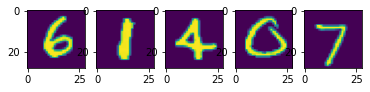

In [5]:
# we create a loader to iterate through the dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       
                   ])),
    batch_size=args.batch_size, shuffle=True,drop_last=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.test_batch_size, shuffle=False,drop_last=True, **kwargs)

first_train_batch_imgs, first_train_batch_labels = next(iter(train_loader))
# set_trace()

f, axarr = pyplot.subplots(1,5)
for i in range(5):
  axarr[i].imshow(first_train_batch_imgs[i,0])
print(f'Labels of the shown images: {first_train_batch_labels[:5]}')

Train Convolutional network for MNIST classification.

In [6]:
# define two functions, one for training the model and one for testing it

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    all_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # put the data on the GPU
        data, target = data.to(device), target.to(device)
        # initialize as zeros all the gradients of the model
        optimizer.zero_grad()
        
        # obtain the predictions in the FORWARD pass of the network
        output = model(data)
        # compute average LOSS for the current batch
        loss = F.nll_loss(output, target)
        all_losses.append(loss.detach().cpu().numpy())
        # BACKPROPAGATE the gradients
        loss.backward()
        # use the computed gradients to OPTIMISE the model
        optimizer.step()
        # print the training loss of each batch
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.array(all_losses).mean()

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        num_iter = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # obtain the prediction by a forward pass
            output = model(data)
            # calculate the loss for the current batch and add it across the entire dataset
            test_loss += F.nll_loss(output, target) # sum up batch loss
            # compute the accuracy of the predictions across the entire dataset
            # get the most probable prediction
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).float().mean().item()
            num_iter += 1
    test_loss /= num_iter
    test_accuracy = 100. * correct / num_iter
    # print the Accuracy for the entire dataset
    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss,
        test_accuracy))
    return test_loss, test_accuracy

Create an optimizer and call the training / testing functions.

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306483
Train Epoch: 1 [9984/60000 (17%)]	Loss: 0.368219
Train Epoch: 1 [19968/60000 (33%)]	Loss: 0.139032
Train Epoch: 1 [29952/60000 (50%)]	Loss: 0.151488
Train Epoch: 1 [39936/60000 (67%)]	Loss: 0.124830
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.172267
Train Epoch: 1 [59904/60000 (100%)]	Loss: 0.116431

Test set: Average loss: 0.0715, Accuracy: (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.086485
Train Epoch: 2 [9984/60000 (17%)]	Loss: 0.056538
Train Epoch: 2 [19968/60000 (33%)]	Loss: 0.044731
Train Epoch: 2 [29952/60000 (50%)]	Loss: 0.092619
Train Epoch: 2 [39936/60000 (67%)]	Loss: 0.025381
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.060633
Train Epoch: 2 [59904/60000 (100%)]	Loss: 0.007102

Test set: Average loss: 0.0426, Accuracy: (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.015226
Train Epoch: 3 [9984/60000 (17%)]	Loss: 0.122417
Train Epoch: 3 [19968/60000 (33%)]	Loss: 0.020671
Train Epoch: 3 [29952/60000 (50%)]	Loss: 0.047925
Train Epoch: 3 [

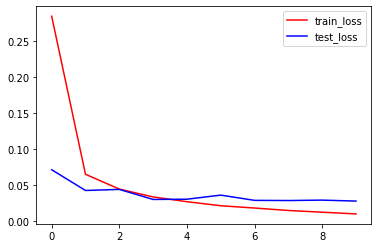

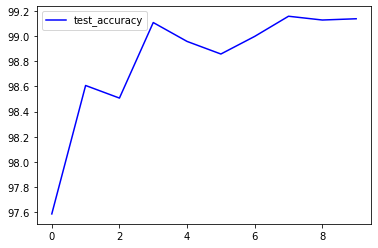

In [7]:
def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.legend()

# move the model to the GPU (when available)
model = CNN().to(device)
# create an Stochastic Gradient Descent optimiser
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

losses_train = []
losses_test = []
accuracy_test = []
for epoch in range(1, args.epochs + 1):
# for epoch in range(1, 3):
    train_loss = train(args, model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(args, model, device, test_loader)
    losses_train.append(train_loss)
    losses_test.append(test_loss)
    accuracy_test.append(test_accuracy)

#plot the loss/accuracy    
pyplot.figure(1)
plot_loss(losses_train,'train_loss','red')
plot_loss(losses_test,'test_loss')
pyplot.figure(2)
plot_loss(accuracy_test,'test_accuracy')

# save the final model
torch.save(model.state_dict(),"mnist_cnn.pt")


# > MNIST counting


---
Load loalisation dataset.
Our goal is to count the digits in every image.

np_dataset_large shape: (5000, 1, 100, 100)
np_dataset_large shape: (1000, 1, 100, 100)


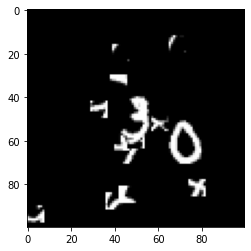

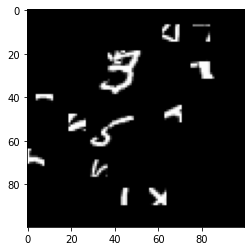

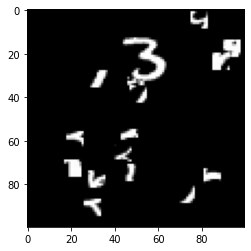

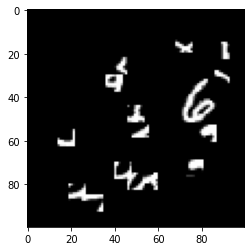

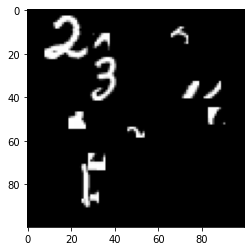

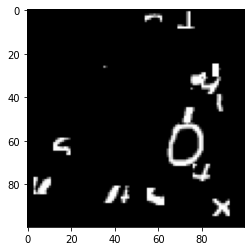

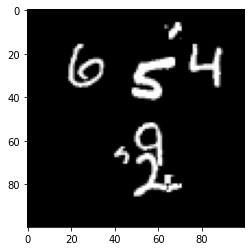

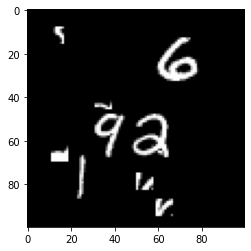

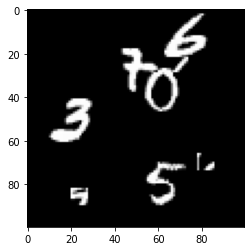

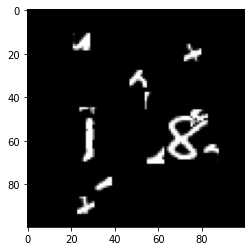

In [8]:
import pickle

def get_large_dataset(path, shuffle=False,first_k=5000):
  # load the dataset as numpy arrays (tensors)
  with open(path,'rb') as handle:
    data = pickle.load(handle)
  # select only first_k elements in the dataset
 
  np_dataset_large  = np.expand_dims(data['images'],1)[:first_k]
  np_dataset_no_count = data['no_count'].astype(np.float32)[:first_k]
  
  # show a couple of examples from the dataset
  print(f'np_dataset_large shape: {np_dataset_large.shape}')
  for ii in range(5):
    example = np_dataset_large[10+ii].reshape((100, 100))
    pyplot.figure()
    pyplot.imshow(example, cmap="gray")
  
  # create loader from the numpy tensors
  from torch.utils.data import TensorDataset
  from torch.utils.data import DataLoader
  dataset_large, dataset_no_count = map(torch.tensor, 
                (np_dataset_large, np_dataset_no_count))
  dataset_large = dataset_large.to(device)
  dataset_no_count = dataset_no_count.to(device)

  large_dataset = TensorDataset(dataset_large, dataset_no_count)
  large_data_loader = DataLoader(large_dataset, 
       batch_size=args.batch_size, shuffle=shuffle, drop_last=True)
  return large_data_loader

# create both train and test dataset
# TODO: change these paths to the place where the pickles are stored in you drive
path_train = '/content/gdrive/MyDrive/Copy of mnist_count_train.pickle'
path_test = '/content/gdrive/MyDrive/Copy of mnist_count_test.pickle'

large_data_loader_train = get_large_dataset(path_train,shuffle=True)
large_data_loader_test = get_large_dataset(path_test)

We will convert the network a fully convolutional network

In [9]:
# design the fully convolutional network   
# the first two conv layers should be the same as the original classification conv layers
# the last two conv layers should be transformed from the last two fully connected layers in the original network
class CNN_fully_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, no_filters1, 5, 1)
        self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
        self.fully_conv1  = nn.Conv2d(no_filter2,no_neurons1, 4)
        self.fully_conv2 = nn.Conv2d(no_neurons1,10, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.fully_conv1(x))
        x = self.fully_conv2(x)
        return F.log_softmax(x, dim=1)

We will run this network on the larger 100x100 images and get 10 maps representing the probability that a digit is found at that location. For every of the 10 feature maps (one for every posible count), we will select the feature maps with the strongest activation.

Save the old classification model, and create a new fully convolutional model from the old parameters.

In [10]:
# data should be in [0,1]
def preprocess(data):
  return data.float() / 255.0
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# save the classification model
PATH = 'conv_net.pt'
torch.save(model.state_dict(), PATH)

# define the fully_conv model
model_fuly_conv = CNN_fully_conv()

# load classification model
loaded_state_dict = torch.load(PATH)

# loaded_state_dict contain the weights of the classification model
# For the fully_conv model we will use exactly the same parameters.
# For the convolutional part we can directly load them as they have the same name.

# We need to convert the last fully-connected layers into convolutions
# For a single neuron we would just reshape the parameters from a vector into a kernel. 
# We just need to know what is the spatial dimension of the original fully-connected input.
# In our case, the first fully-connected had an input of size 4 x 4 x no_filter2, so we must use kernels of size 4 x 4 x no_filter2
# The second fully-connected receives as input just a vector(1x1 spatial dimension) of size no_neurons1 thus we use kernels of size 1 x 1 x no_neurons1
model_dict = {}
for key,val in loaded_state_dict.items():
  key = key.replace('fc','fully_conv')
  print(f'key: {key}')
  if 'fully_conv1.weight' in key:
    val = val.view(-1,no_filter2,4,4)
  if 'fully_conv2.weigh' in key:
    val = val.view(-1,no_neurons1,1,1)
  model_dict[key] = val
  
model_fuly_conv.load_state_dict(model_dict)
model_fuly_conv = model_fuly_conv.to(device)

print(model_fuly_conv.parameters)

Model's state_dict:
conv1.weight 	 torch.Size([20, 1, 5, 5])
conv1.bias 	 torch.Size([20])
conv2.weight 	 torch.Size([50, 20, 5, 5])
conv2.bias 	 torch.Size([50])
fc1.weight 	 torch.Size([500, 800])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])
key: conv1.weight
key: conv1.bias
key: conv2.weight
key: conv2.bias
key: fully_conv1.weight
key: fully_conv1.bias
key: fully_conv2.weight
key: fully_conv2.bias
<bound method Module.parameters of CNN_fully_conv(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fully_conv1): Conv2d(50, 500, kernel_size=(4, 4), stride=(1, 1))
  (fully_conv2): Conv2d(500, 10, kernel_size=(1, 1), stride=(1, 1))
)>


Evaluate this fully convolutional network.

In [11]:
threshold = -3.0611e-04

# iterate over all the batches and estimate the n of the digits for each sample
for batch_idx, (large_imgs, target_no_count) in enumerate(large_data_loader_test):
  large_imgs = preprocess(large_imgs)
  out_prob_maps = model_fuly_conv(large_imgs)
  # from the 10 maps, we sort them, and select from the first 5, the indexes bigger than a Threshold
  sorted = torch.max(out_prob_maps.view(args.batch_size,10,-1),dim=2)[0]
  no_count = torch.sum(torch.gt(sorted,threshold),dim=1)
  for i in range(len(no_count)):
    if no_count[i]>5:
      no_count[i] = 5
  #Report accuracy for each batch
  a = (no_count==target_no_count).sum(0)/no_count.shape[0]
  print(f'Accuracy on batch {batch_idx}: {a}')


Accuracy on batch 0: 0.234375
Accuracy on batch 1: 0.265625
Accuracy on batch 2: 0.28125
Accuracy on batch 3: 0.3125
Accuracy on batch 4: 0.1875
Accuracy on batch 5: 0.21875
Accuracy on batch 6: 0.21875
Accuracy on batch 7: 0.265625
Accuracy on batch 8: 0.203125
Accuracy on batch 9: 0.234375
Accuracy on batch 10: 0.3125
Accuracy on batch 11: 0.265625
Accuracy on batch 12: 0.3125
Accuracy on batch 13: 0.234375
Accuracy on batch 14: 0.234375


# Learn new localisation model.

We will train a network to directly predict number of the digits from the whole 100x100 image. 
For this we will design a network similar with the original classification network that directly predict the no. The output would be a number from 1 to 5. The first part of the localisation network will share the first part of the fully convolutional classification network.

In [12]:
# design the counting network

no_filters1 = 20
no_filter2 = 50
no_neurons1 = 500

class CNN_count(nn.Module):
  def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, no_filters1, 5, 1)
      self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
      self.fully_conv1  = nn.Conv2d(no_filter2,no_neurons1, 4)
      self.fully_conv2_new = nn.Conv2d(no_neurons1,10, 1)
      # add a linear layer 
      self.linear_loc = nn.Linear(19*19*10,5)
      
  def forward(self, xb):
      x = xb.view(-1, 1, xb.shape[2], xb.shape[3])
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.fully_conv1(x))
      self.conv_act = self.fully_conv2_new(x).view(args.batch_size,-1)
      self.lin = self.linear_loc(self.conv_act)
      self.lsfm = F.log_softmax(self.lin, dim = 1)
      return self.lsfm

In [13]:
import sklearn.metrics
def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.legend()
# train localisation model
def train_count(args, model, device, train_loader, optimizer, epoch):
    model.train()
    acc = 0
    all_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      target = target - 1
      data = preprocess(data)        
      optimizer.zero_grad()
      output = model(data)
      loss = F.nll_loss(output, target.type(torch.LongTensor))     
      loss.backward()
      pred = output.argmax(dim = 1, keepdim = True)
      #print(pred.flatten())
      #print(target)
      all_losses.append(loss.data.cpu().numpy())
      optimizer.step()
      if batch_idx % 16 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
             epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
    return np.array(all_losses).mean()
def test_count(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        num_iter = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target = target - 1
            data = preprocess(data)
            output = model(data)
            test_loss += F.nll_loss(output, target.type(torch.LongTensor)).item()
            pred = output.argmax(dim = 1, keepdim = True)
            #print(pred.flatten())
            #print(target)
            correct += pred.eq(target.view_as(pred)).float().mean().item()
            num_iter += 1
    test_loss /= num_iter
    test_accuracy = 100. * correct / num_iter
    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss,
        test_accuracy))
    return test_loss, test_accuracy

We will train two variants of the network:

*   We randomly initialize the network and train it for the localisation task.
(from scratch) .
*   We initialize the parameters from the previously trained classification network. (transfer learning).

In [15]:
# save classification model
PATH = 'conv_net.pt'
torch.save(model.state_dict(), PATH)

loc_model_scratch = CNN_count()

loc_model_scratch = loc_model_scratch.to(device)

optimizer_loc_scratch = optim.SGD(
    loc_model_scratch.parameters(), lr=args.lr, momentum=args.momentum)

losses_train = []
losses_test = []
accuracy_test = []
for epoch in range(1, args.epochs+20):
  
    print(f'Scratch epoch: {epoch}')
    train_loss = train_count(args, loc_model_scratch, device, large_data_loader_train, optimizer_loc_scratch, epoch)
    test_loss, test_accuracy = test_count(args, loc_model_scratch, device, large_data_loader_test)
    
    losses_train.append(train_loss)
    losses_test.append(test_loss)
    accuracy_test.append(test_accuracy)


Scratch epoch: 1
Train Epoch: 1 [0/5000 (0%)]	Loss: 1.608023
Train Epoch: 1 [1024/5000 (21%)]	Loss: 1.610021
Train Epoch: 1 [2048/5000 (41%)]	Loss: 1.607924
Train Epoch: 1 [3072/5000 (62%)]	Loss: 1.612196
Train Epoch: 1 [4096/5000 (82%)]	Loss: 1.610489

Test set: Average loss: 1.6054, Accuracy: (19%)

Scratch epoch: 2
Train Epoch: 2 [0/5000 (0%)]	Loss: 1.610593
Train Epoch: 2 [1024/5000 (21%)]	Loss: 1.583637
Train Epoch: 2 [2048/5000 (41%)]	Loss: 1.611531
Train Epoch: 2 [3072/5000 (62%)]	Loss: 1.588399
Train Epoch: 2 [4096/5000 (82%)]	Loss: 1.424969

Test set: Average loss: 1.3390, Accuracy: (38%)

Scratch epoch: 3
Train Epoch: 3 [0/5000 (0%)]	Loss: 1.284498
Train Epoch: 3 [1024/5000 (21%)]	Loss: 1.509772
Train Epoch: 3 [2048/5000 (41%)]	Loss: 1.233033
Train Epoch: 3 [3072/5000 (62%)]	Loss: 1.344939
Train Epoch: 3 [4096/5000 (82%)]	Loss: 1.301841

Test set: Average loss: 1.1901, Accuracy: (43%)

Scratch epoch: 4
Train Epoch: 4 [0/5000 (0%)]	Loss: 1.211563
Train Epoch: 4 [1024/5000 (21%

Plot the losses and accuracy

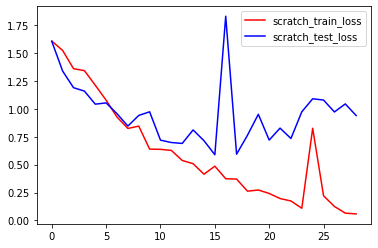

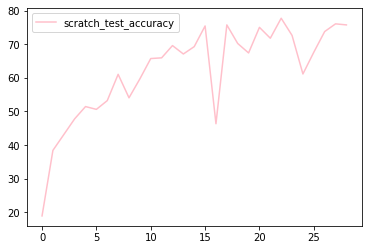

In [27]:
pyplot.figure(1)
plot_loss(losses_train,'scratch_train_loss','red')
plot_loss(losses_test,'scratch_test_loss')

pyplot.figure(2)
plot_loss(accuracy_test,'scratch_test_accuracy','pink')

Investigate the effect of pretraining on the accuracy, depending on the number of samples used in training. We train  two models, where one has some layers pre-trained on MNIST clas-
sification and the other one has all the layers randomly initialized. We compare their accuracy when using 20%, 50%, 100% of the training data. 

key: conv1.weight
key: conv1.bias
key: conv2.weight
key: conv2.bias
key: fully_conv1.weight
key: fully_conv1.bias
key: fully_conv2.weight
key: fully_conv2.bias
np_dataset_large shape: (1000, 1, 100, 100)
Pretrained epoch: 1
Train Epoch: 1 [0/1000 (0%)]	Loss: 1.609119

Test set: Average loss: 1.6097, Accuracy: (18%)

Pretrained epoch: 2
Train Epoch: 2 [0/1000 (0%)]	Loss: 1.606040

Test set: Average loss: 1.6086, Accuracy: (21%)

Pretrained epoch: 3
Train Epoch: 3 [0/1000 (0%)]	Loss: 1.611421

Test set: Average loss: 1.6051, Accuracy: (22%)

Pretrained epoch: 4
Train Epoch: 4 [0/1000 (0%)]	Loss: 1.601153

Test set: Average loss: 1.5949, Accuracy: (24%)

Pretrained epoch: 5
Train Epoch: 5 [0/1000 (0%)]	Loss: 1.579061

Test set: Average loss: 1.5856, Accuracy: (24%)

Pretrained epoch: 6
Train Epoch: 6 [0/1000 (0%)]	Loss: 1.495555

Test set: Average loss: 1.4994, Accuracy: (30%)

Pretrained epoch: 7
Train Epoch: 7 [0/1000 (0%)]	Loss: 1.352986

Test set: Average loss: 1.7595, Accuracy: (26%)

AttributeError: ignored

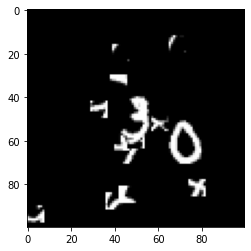

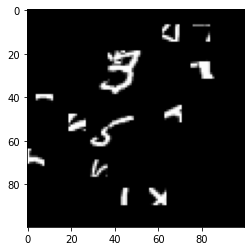

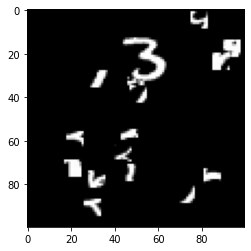

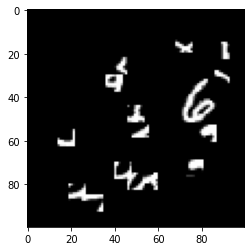

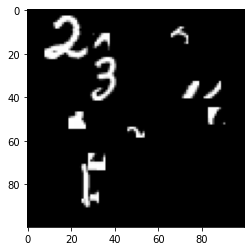

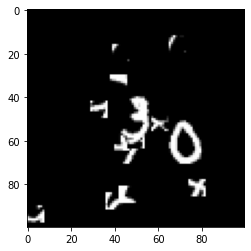

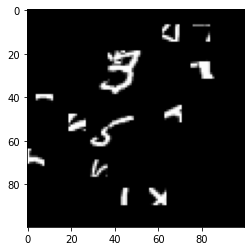

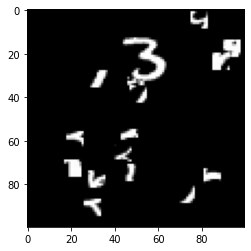

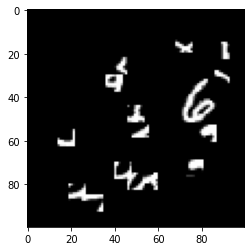

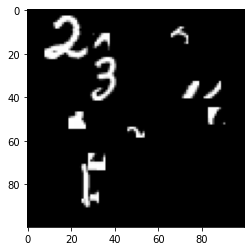

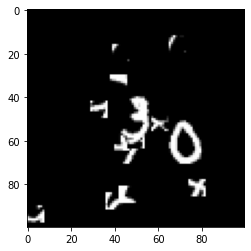

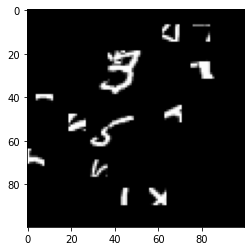

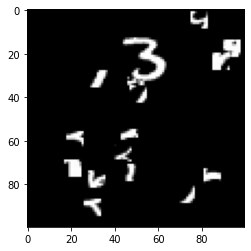

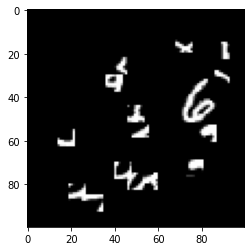

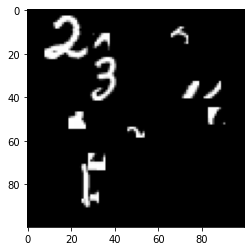

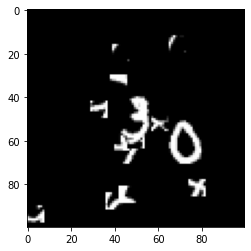

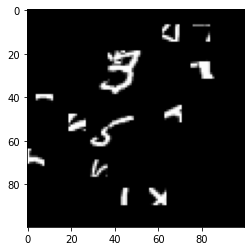

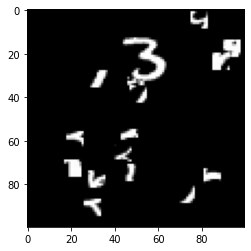

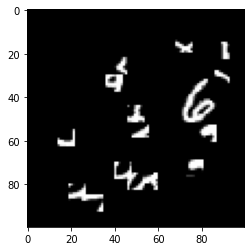

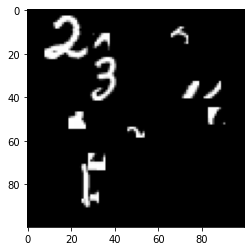

In [30]:
# we will train 2 models, one with random initialisation, 
# one with parameters initialised from the classification network

def train_pretrain(persentage = 1):
    loc_model_pretrained = CNN_count()

    # convert the fully-connected into convolutional layers
    loaded_state_dict = torch.load(PATH)
    model_dict = {}
    for key,val in loaded_state_dict.items():
      key = key.replace('fc','fully_conv')
      print(f'key: {key}')
      if 'fully_conv1.weight' in key:
        val = val.view(-1,no_filter2,4,4)
      if 'fully_conv2.weigh' in key:
        val = val.view(-1,no_neurons1,1,1)
        model_dict[key] = val

# load pretrained classification parameters into localisation model
    loc_model_pretrained.load_state_dict(model_dict, strict=False)
    loc_model_pretrained = loc_model_pretrained.to(device)

    loc_model_pretrained.linear_loc.weight.data

    optimizer_loc_pretrained = optim.SGD(
        loc_model_pretrained.parameters(), lr=args.lr, momentum=args.momentum)
    
    accuracy_test_pre = []
    train_loader = get_large_dataset(path_train,shuffle=True, first_k=int(5000*persentage))
    for epoch in range(1, args.epochs+10):
        print(f'Pretrained epoch: {epoch}')
        train_loss= train_count(args, loc_model_pretrained, device,train_loader, optimizer_loc_pretrained, epoch)
        test_loss, accuracy_test = test_count(args, loc_model_pretrained, device, large_data_loader_test)
    
        accuracy_test_pre.append(accuracy_test)

    return np.array(accuracy_test_pre).mean()

accuracy_20 = train_pretrain(persentage = 0.2)
accuracy_50 = train_pretrain(persentage = 0.5)
accuracy_100 = train_pretrain()
"""
def train_scratch(persentage):
    loc_model_scratch = CNN_count()

    loc_model_scratch = loc_model_scratch.to(device)

    optimizer_loc_scratch = optim.SGD(
        loc_model_scratch.parameters(), lr=args.lr, momentum=args.momentum)
    accuracy_test = []

    train_loader = get_large_dataset(path_train,shuffle=True, first_k=int(5000*persentage))

    for epoch in range(1, args.epochs+10):
  
        print(f'Scratch epoch: {epoch}')
        train_loss = train_count(args, loc_model_scratch, device, train_loader, optimizer_loc_scratch, epoch)
        test_loss, test_accuracy = test_count(args, loc_model_scratch, device, large_data_loader_test)
    
        accuracy_test.append(test_accuracy)
    return np.array(accuracy_test).mean()

#return np.array(accuracy_test.mean())""" 

np_dataset_large shape: (1000, 1, 100, 100)
Scratch epoch: 1
Train Epoch: 1 [0/1000 (0%)]	Loss: 1.611192

Test set: Average loss: 1.6090, Accuracy: (21%)

Scratch epoch: 2
Train Epoch: 2 [0/1000 (0%)]	Loss: 1.607997

Test set: Average loss: 1.6069, Accuracy: (20%)

Scratch epoch: 3
Train Epoch: 3 [0/1000 (0%)]	Loss: 1.606708

Test set: Average loss: 1.6028, Accuracy: (21%)

Scratch epoch: 4
Train Epoch: 4 [0/1000 (0%)]	Loss: 1.606715

Test set: Average loss: 1.5866, Accuracy: (28%)

Scratch epoch: 5
Train Epoch: 5 [0/1000 (0%)]	Loss: 1.580381

Test set: Average loss: 1.5435, Accuracy: (29%)

Scratch epoch: 6
Train Epoch: 6 [0/1000 (0%)]	Loss: 1.499760

Test set: Average loss: 1.7634, Accuracy: (25%)

Scratch epoch: 7
Train Epoch: 7 [0/1000 (0%)]	Loss: 1.772053

Test set: Average loss: 1.3872, Accuracy: (35%)

Scratch epoch: 8
Train Epoch: 8 [0/1000 (0%)]	Loss: 1.301812

Test set: Average loss: 1.4213, Accuracy: (37%)

Scratch epoch: 9
Train Epoch: 9 [0/1000 (0%)]	Loss: 1.173815

Test s

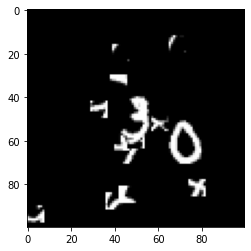

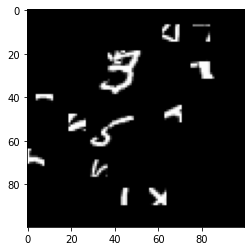

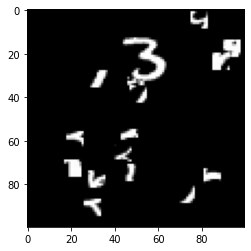

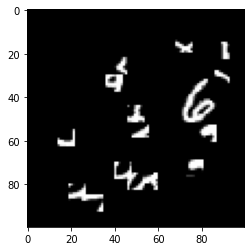

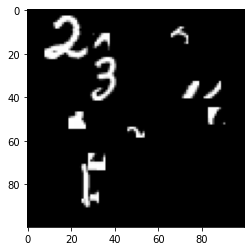

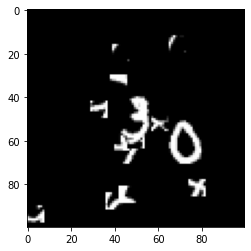

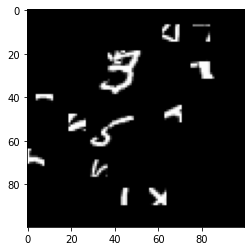

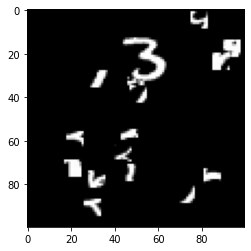

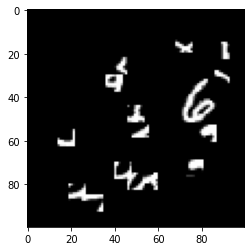

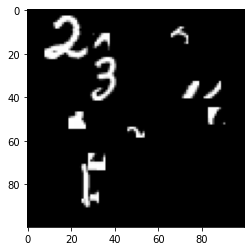

In [35]:
def train_scratch(persentage):
    loc_model_scratch = CNN_count()

    loc_model_scratch = loc_model_scratch.to(device)

    optimizer_loc_scratch = optim.SGD(
        loc_model_scratch.parameters(), lr=args.lr, momentum=args.momentum)
    accuracy_test = []

    train_loader = get_large_dataset(path_train,shuffle=True, first_k=int(5000*persentage))

    for epoch in range(1, args.epochs+10):
  
        print(f'Scratch epoch: {epoch}')
        train_loss = train_count(args, loc_model_scratch, device, train_loader, optimizer_loc_scratch, epoch)
        test_loss, test_accuracy = test_count(args, loc_model_scratch, device, large_data_loader_test)
    
        accuracy_test.append(test_accuracy)
    return np.array(accuracy_test).mean()


accuracy_20_pre = train_scratch(persentage = 0.2)
accuracy_50_pre = train_scratch(persentage = 0.5)
accuracy_100_pre = np.array(accuracy_test).mean()

Plot the final accuracy of all models in
the same figure, where the Ox axis represents the fraction of data used and the Oy axis represents the final accuracy.

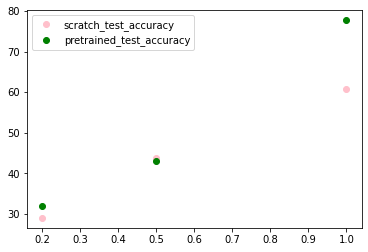

In [46]:
y = [0.2, 0.5, 1] #persentage of data
pyplot.plot(y,[accuracy_20,accuracy_50, accuracy_100],'ro',label='scratch_test_accuracy',color='pink')
pyplot.plot(y,[accuracy_20_pre,accuracy_50_pre,accuracy_100_pre],'ro',label='pretrained_test_accuracy',color='green')
pyplot.legend()